# Homework 1

### Task 1 
**Describe a machine learning problem that you would like to solve using Logistic Regression. Clearly state why Logistic regression is the best choice for solving this problem.**


The problem of predicting credit defaults is an are where logistic regression can thrive. We must be able to predict the likelihood of an individual to default on their credit card. There are many variables to calculate the credit default probability. Thus, logistic regression would be the ideal choice to predict this probability. 

### Task 2

**Pick a publicly available dataset (except The Titanic Dataset because we already discussed that in class) that you will use to solve this problem. You must provide a link to the dataset and perform necessary Exploratory Data Analysis (EDA). Clearly demonstrate the steps you follow for your EDA with a justification of why these were required. For example, if the dataset has lot of missing values, then why did you use a specific technique when handling missing data. This task may include data visualization (Check this link : https://www.geeksforgeeks.org/top-8-python-libraries-for-data-visualization/).**

The dataset that is used is from this link: https://www.kaggle.com/datasets/gauravtopre/credit-card-defaulter-prediction.

Before I preprocessed the data, I removed the `ID` column as it is not relevant to the data. Then I proceeded to one hot encode the categorical variables to allow for logistic regression to use the features as numerical values. There were no missing values in the dataset so I did not need to clean the dataset. I split the data into training and testing data with a split of 80% training and 20% test. Then, I normalized the data such that the training data had 0 mean and std of 1. I saved these values and applied them to the test set. 

In [16]:
import os 
import pandas as pd

folder_name = "./credit-card-defaulter-prediction"
file_name = "Credit Card Defaulter Prediction.csv"


if not os.path.exists(folder_name):
    import opendatasets as od
    # download the data
    dataset_link = "https://www.kaggle.com/datasets/gauravtopre/credit-card-defaulter-prediction"
    od.download(dataset_link)

data = pd.read_csv(os.path.join(folder_name, file_name))
data = data.drop('ID', axis=1)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,F,University,Married,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,Y
1,120000,F,University,Single,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,Y
2,90000,F,University,Single,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,N
3,50000,F,University,Married,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,N
4,50000,M,University,Married,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,N


In [17]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

one_hot_labels =  ['EDUCATION', 'MARRIAGE', 'SEX'] + ['PAY_{}'.format(x) for x in [0,2,3,4,6]] + ['default ']
y_label = 'default '

train_proportion = 0.8
cutoff = int(len(data) * train_proportion)


# one hot encode the categorical variables
def get_mapping(column):
    unique_matches = set()

    for item in column:
        unique_matches.add(item)

    mapping = {}
    for i, item in enumerate(unique_matches):
        mapping[item] = i

    return mapping
    
def transform(mapping, column):
    out = np.zeros((len(mapping), len(column)), dtype=np.float32)
    for i, item in enumerate(column):
        out[mapping[item]][i] = 1.0

    return out

for label in one_hot_labels:
    column = data.loc[:,label]
    data = data.drop(label, axis=1)
    mapping = get_mapping(column)
    new_labels = ['{}_{}'.format(label, index) for index in range(len(mapping))]
    for label, encoding in zip(new_labels, transform(mapping, column)):
        data[label] = encoding

# randomly separate testing / training data
numeric_data = data.to_numpy()
np.random.shuffle(numeric_data)
train_data_x = numeric_data[0:cutoff,:-1]
train_data_y = numeric_data[0:cutoff,-1]
test_data_x = numeric_data[cutoff:,:-1]
test_data_y = numeric_data[cutoff:,-1]

# -- normalize the data --
mean = np.mean(train_data_x, axis=0)
std = np.std(train_data_x, axis=0)

train_data = np.divide(train_data_x - mean, std), train_data_y
test_data = np.divide(test_data_x - mean, std), test_data_y

### Task 3

**Implement, Logistic Regression in this step. Clearly write your cost function and derivatives before implementing gradient descent. Do not use any built-in packages for this step. You can use the vectorization techniques demonstrated in class. Implement any 2 variants of gradient descent in their original form. (Refer to the research paper discussed in class).**

In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegressionModel:
    def __init__(self, cost_fn, input_features):
        self.cost_fn = cost_fn
        self.weights = np.zeros((input_features, 1))
        self.bias = np.zeros((1,))

    def _calculate_gradient(self, X, Y_hat, Y):
        return (
            np.dot(X.T, (Y_hat-Y).T) / Y.shape[0], 
            np.sum(Y_hat-Y) / Y.shape[0]
        )

    def forward(self, X):
        return sigmoid(np.dot(self.weights.T, X.T) + self.bias)

    def gradient_update(self, learning_rate, X, Y_hat, Y):
        dw, db = self._calculate_gradient(X, Y_hat, Y)

        self.weights -= dw * learning_rate
        self.bias -= db * learning_rate

    def _calculate_loss(self, Y_hat, Y):
        return self.cost_fn(Y_hat, Y)

    def evaluate(self, dataset):
        X, Y = dataset
        Y_hat = self.forward(X)
        return self._calculate_loss(Y_hat, Y)

def cost_fn(Y_hat, Y):
    assert Y_hat.flatten().shape == Y.flatten().shape
    return (
        -1 / Y_hat.shape[0] 
        * np.sum(Y * np.log(Y_hat) 
        + (1 - Y) * (np.log(1 - Y_hat)))
    )
    
def fit_sgd(dataset_train, dataset_test, epochs, learning_rate, input_features):
    model = LogisticRegressionModel(cost_fn=cost_fn, input_features=input_features)
    X_train, Y_train = dataset_train

    history = []

    for _ in tqdm(range(epochs)):
        for i in range(len(X_train)):
            X = np.array([X_train[i]])
            Y = np.array([Y_train[i]])
            Y_hat = model.forward(X)
            model.gradient_update(learning_rate, X, Y_hat, Y)

        history.append(model.evaluate(dataset_test))

    return history, model.evaluate(dataset_test)



def fit_batched(dataset_train, dataset_test, epochs, learning_rate, input_features):
    model = LogisticRegressionModel(cost_fn=cost_fn, input_features=input_features)
    X, Y = dataset_train

    history = []

    for _ in tqdm(range(epochs)):
        Y_hat = model.forward(X)
        model.gradient_update(learning_rate, X, Y_hat, Y)

        history.append(model.evaluate(dataset_test))

    return history, model.evaluate(dataset_test)


100%|██████████| 5000/5000 [00:07<00:00, 679.39it/s]


12.121797580377013


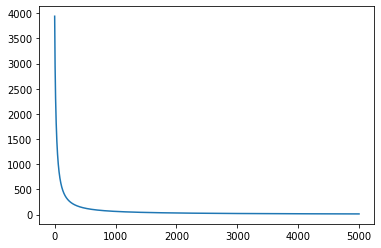

In [19]:
epochs = 5000
history, loss = fit_batched(train_data, test_data, epochs, 1E-1, train_data[0].shape[1])

print(loss)
plt.plot(range(epochs), history)

100%|██████████| 30/30 [00:26<00:00,  1.15it/s]

8.887534700514072


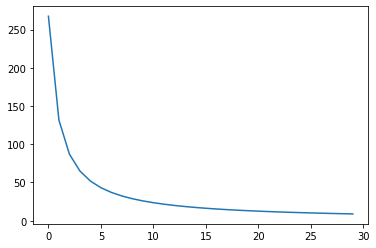

In [20]:
epochs = 30
history, loss = fit_sgd(train_data, test_data, epochs, 1E-3, train_data[0].shape[1])

print(loss)
plt.plot(range(epochs), history)

### Task 4

**Pick any 2 optimization algorithms that are used to optimize the ‘vanilla’ gradient descent. Implement both. You may implement these algorithms yourself OR use a package. In your conclusion, compare both optimization techniques/algorithms with respect to the results you achieve. Also 
compare these results with the original implementation of gradient descent (Task 3 above). Describe why or why not should we use optimization algorithms for the task at hand.**

The results for the optimizers seems to slightly outperform the the standard gradient decent algorithm. However, in training the models the ones with optimizers seem to be more resilient to small hyperparameter changes. For example, in the SGD optimization for task 3 a learning rate of >=1E-2 would result in a exploding gradient. However, to achieve the results the batched gradient decent seemed to be the fastest method to converge to comperable results with the rest of the models (8 seconds). 

In [55]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop

def get_model(dataset, optimizer):
    model = tf.keras.Sequential([
        Dense(1, input_shape=(dataset.shape[1],), activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model



model_adam = get_model(train_data[0], Adam(learning_rate=1E4))
model_rms = get_model(train_data[0], RMSprop(learning_rate=1E4))

In [53]:
model_adam.fit(x=train_data[0], y=train_data[1], epochs=30, batch_size=32, validation_data=test_data)

Train on 24000 samples, validate on 6000 samples
Epoch 1/30
24000/24000 [==============================] - 2s 100us/sample - loss: 14535.8306 - val_loss: 7914.9377
Epoch 2/30
24000/24000 [==============================] - 1s 52us/sample - loss: 5030.1555 - val_loss: 2533.9880
Epoch 3/30
24000/24000 [==============================] - 3s 108us/sample - loss: 2214.8532 - val_loss: 1835.5588
Epoch 4/30
24000/24000 [==============================] - 2s 71us/sample - loss: 1725.3165 - val_loss: 1465.0818
Epoch 5/30
24000/24000 [==============================] - 1s 50us/sample - loss: 1400.3673 - val_loss: 1197.8580
Epoch 6/30
24000/24000 [==============================] - 1s 47us/sample - loss: 1136.5743 - val_loss: 974.8214
Epoch 7/30
24000/24000 [==============================] - 1s 51us/sample - loss: 909.1082 - val_loss: 783.5745
Epoch 8/30
24000/24000 [==============================] - 1s 47us/sample - loss: 723.2540 - val_loss: 633.4319
Epoch 9/30
24000/24000 [=========================

In [56]:
model_rms.fit(x=train_data[0], y=train_data[1], epochs=30, batch_size=32, validation_data=test_data)

Train on 24000 samples, validate on 6000 samples
Epoch 1/30
24000/24000 [==============================] - 6s 254us/sample - loss: 15277.8948 - val_loss: 9093.1571
Epoch 2/30
24000/24000 [==============================] - 3s 127us/sample - loss: 6113.3312 - val_loss: 3568.5807
Epoch 3/30
24000/24000 [==============================] - 2s 104us/sample - loss: 3124.5484 - val_loss: 2569.9029
Epoch 4/30
24000/24000 [==============================] - 2s 63us/sample - loss: 2269.9909 - val_loss: 1858.7221
Epoch 5/30
24000/24000 [==============================] - 1s 61us/sample - loss: 1699.9077 - val_loss: 1418.1838
Epoch 6/30
24000/24000 [==============================] - 1s 59us/sample - loss: 1361.3401 - val_loss: 1161.3027
Epoch 7/30
24000/24000 [==============================] - 1s 60us/sample - loss: 1165.8984 - val_loss: 1001.3409
Epoch 8/30
24000/24000 [==============================] - 1s 54us/sample - loss: 1024.6627 - val_loss: 873.5212
Epoch 9/30
24000/24000 [====================

# HW 2

In [35]:
from sklearn import tree
from sklearn.metrics import accuracy_score

In [36]:
dt = tree.DecisionTreeClassifier()

dt.fit(train_data[0], train_data[1])
print("train", accuracy_score(train_data[1], dt.predict(train_data[0])))
print("test", accuracy_score(test_data[1], dt.predict(test_data[0])))


train 1.0
test 1.0


Unfortunatly, the decision tree classifier is already at 100% accuracy so we cannot see how changing the parameters aid in overfitting or how we can improve the variance. We can change the parameters to make the model worse. The only parameter that I could change that affects either of the accuracies was the max_features. The reason this affects the accuracy is quite intuitive as we are simply reducing `max_features` to 1 which reduces the available information to the model. It is therefore not able to find a pattern to the data. It Looks from the results below that the variance increased as the test accuracy by doing this but more likely the bias increased and we are unable to see the effect of that as the accuracy is too high to see an effect. We cannot know for sure though unless we chose a different dataset. 

In [38]:
dt = tree.DecisionTreeClassifier(max_features=1)

dt.fit(train_data[0], train_data[1])

print("train", accuracy_score(train_data[1], dt.predict(train_data[0])))
print("test", accuracy_score(test_data[1], dt.predict(test_data[0])))


train 1.0
test 0.8411666666666666
